# GE Bracket

Geometry from the GE jet engine bracket challenge: https://grabcad.com/challenges/ge-jet-engine-bracket-challenge

Load cases considered in the optimization: 35.6 kN vertical force / 37.8 kN horizontal force

For numerical reasons, the force was rescaled by a factor of 0.01. Therefore, to obtain the actual compliance it is necessary to multiply the output by 10000 and to obtain the actual displament it is necessary to multiply the output by 100.

Ansys model:
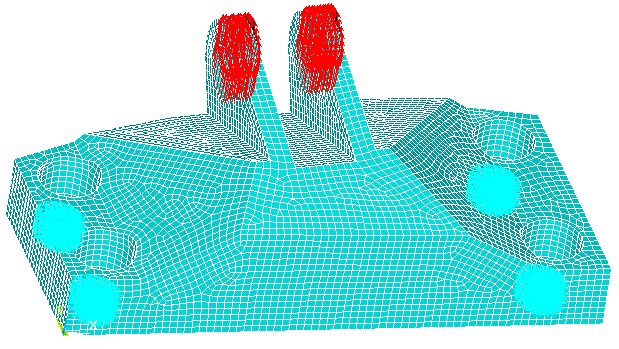

In [1]:
import os, sys
path = os.path.abspath(os.path.join('..'))
os.chdir(path)
if path not in sys.path:
    sys.path.append(path)

In [2]:
import matplotlib.pyplot as plt
import niceplots
plt.style.use(niceplots.get_style())

import pyvista as pv
pv.set_plot_theme('document')
pv.set_jupyter_backend('static')

import numpy as np
from optim import TopOpt, Post3D

In [3]:
# {t/mm^3, MPa, -, kgCO2/kg}
flax = {'rho': 1470e-12, 'E': 53.5e3, 'v': 0.355, 'CO2': 0.44}
pla  = {'rho': 1290e-12, 'E': 3.45e3, 'v': 0.39,  'CO2': 2.28}
Vfiber  = 0.5

Ex, Ey, nuxy, nuyz, Gxy, rho, CO2mat = TopOpt.rule_mixtures(fiber=flax, matrix=pla, Vfiber=Vfiber)
CO2veh = 1030 * 25 * 3.83 # kg_fuel/kg_transported/year * years * kgCO2/kg_fuel = kgCO2/kg

In [ ]:
a = 90
theta0 = np.linspace(-90, 90, num=18, endpoint=False).astype(int)
compliance = []
printability = []
iter = []
t = []
for theta in theta0:
    jobname = str(theta).replace('-','n')
    solver = TopOpt(inputfile='models/bracket.db', load_cases=('models/bracket_ver.s01', 'models/bracket_hor.s01'), res_dir=f'results/workflow/refine/{jobname}/',
            dim='3D_layer', jobname=jobname, echo=False)
    solver.set_material(Ex=Ex, Ey=Ey, nuxy=nuxy, nuyz=nuxy, Gxy=Gxy)
    solver.set_volfrac(0.2)
    solver.set_filters(r_rho=5, r_theta=7)
    solver.set_print_direction(print_direction=(0.,np.cos(np.deg2rad(a)),np.sin(np.deg2rad(a))))
    solver.set_initial_conditions('fix', theta0=theta)
    solver.set_optim_options(max_iter=50, tol=5e-3, continuation=True)

    region1 = np.where((solver.centers[:,0]-15.5)**2 + (solver.centers[:,1]-13.5)**2 < 8**2)[0]
    region2 = np.where((solver.centers[:,0]-15.2)**2 + (solver.centers[:,1]-51.8)**2 < 8**2)[0]
    region3 = np.where((solver.centers[:,0]-163.2)**2 + (solver.centers[:,1]-47.3)**2 < 8**2)[0]
    region4 = np.where((solver.centers[:,0]-163.2)**2 + (solver.centers[:,1]+4.9)**2 < 8**2)[0]
    region5 = np.where((solver.centers[:,1]-73)**2 + (solver.centers[:,2]-40.5)**2 < 15**2)[0]
    solid = np.concatenate([region1, region2, region3, region4, region5])
    solver.set_solid_elem(solid)

    solver.run()
    solver.save()

    compliance   += [solver.comp_norm_max_hist[-1]]
    printability += [solver.get_printability()[0]]
    iter         += [solver.mma.iter]
    t            += [solver.time]

    del solver

In [6]:
theta0 = np.linspace(-90, 90, num=18, endpoint=False).astype(int)
print('-'*(21*5+1))
print(('|{:^20}'*5+'|').format('theta0 (°)','C (N.mm)', 'Printability (%)','Iter','Time (s)'))
print('-'*(21*5+1))
for theta, c, p, i, tt in zip(theta0, compliance, printability, iter, t):
    print(('|{:^20}|{:^20.3f}|{:^20.1f}|{:^20}|{:^20.2f}|').format(theta,c,100*p,i,tt))
print('-'*(21*5+1))

----------------------------------------------------------------------------------------------------------
|     theta0 (°)     |      C (N.mm)      |  Printability (%)  |        Iter        |      Time (s)      |
----------------------------------------------------------------------------------------------------------
|        -90         |       27.462       |        73.7        |         42         |      3127.51       |
|        -80         |       27.535       |        73.3        |         43         |      3864.06       |
|        -70         |       27.412       |        73.6        |         45         |      2740.02       |
|        -60         |       29.153       |        74.2        |         40         |      2827.00       |
|        -50         |       30.235       |        76.8        |         43         |      3604.41       |
|        -40         |       28.164       |        74.1        |         47         |      6179.73       |
|        -30         |       28.139  

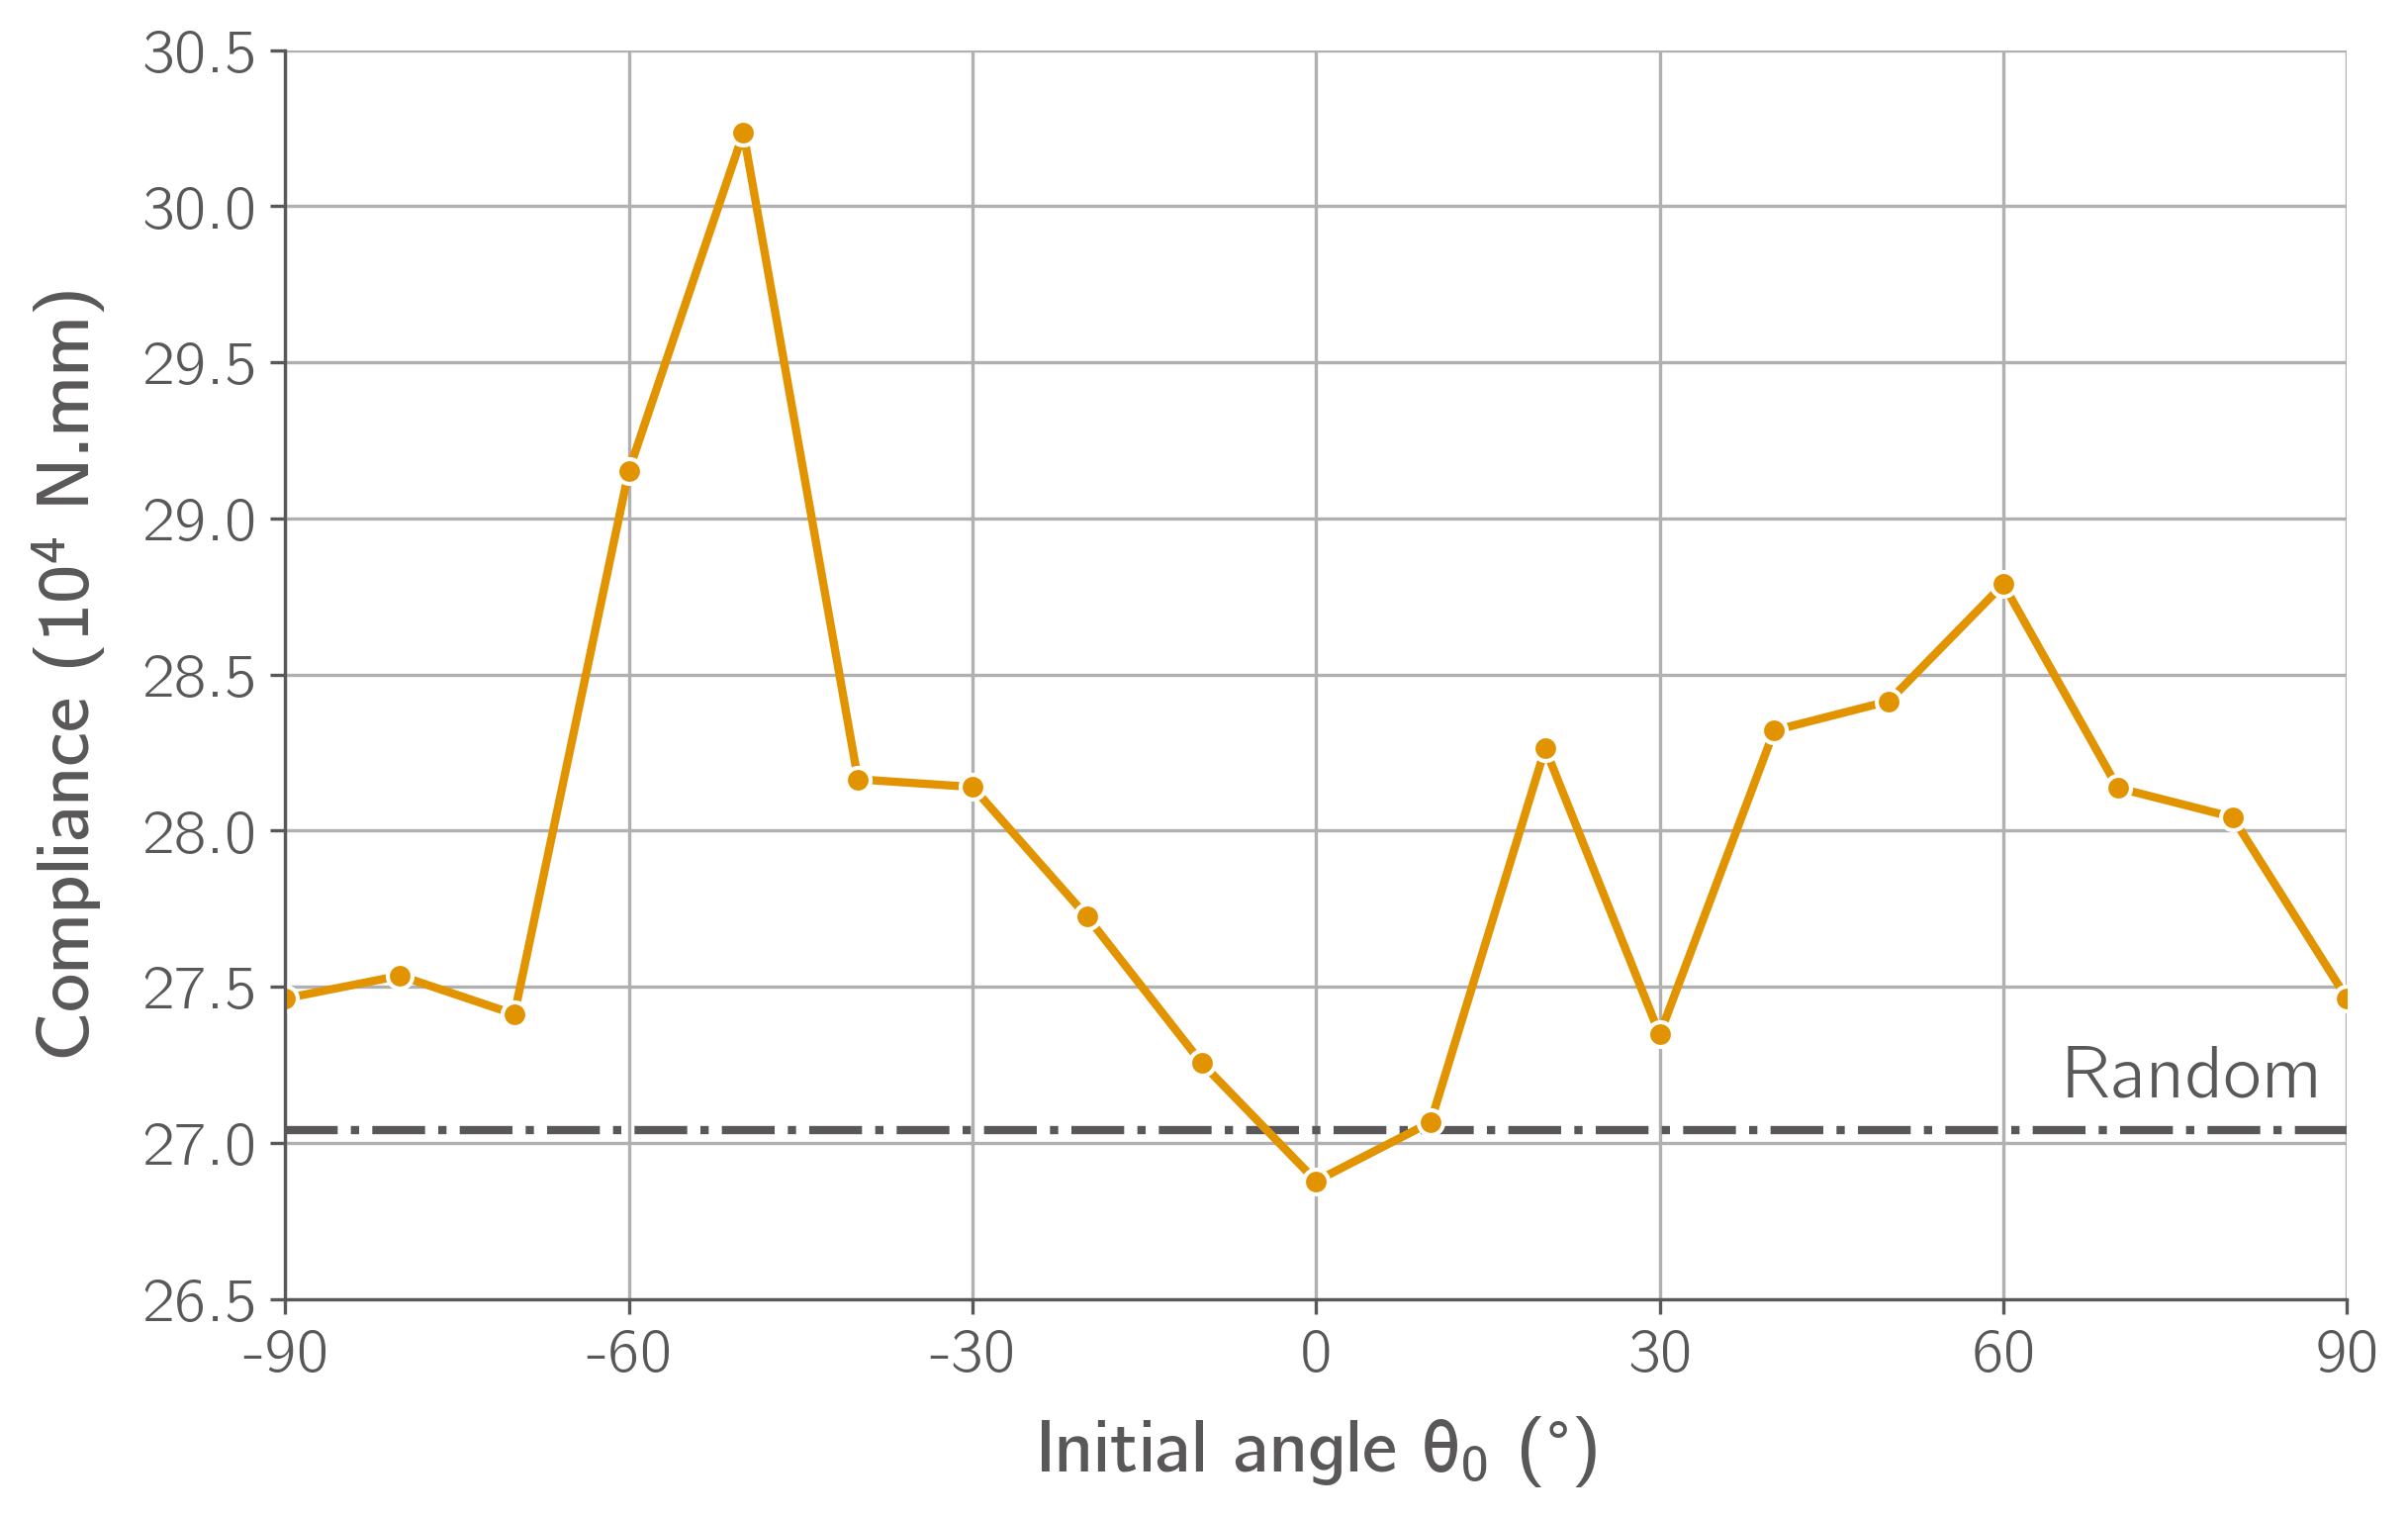

In [14]:
# compliance = []

# theta0 = np.linspace(-90, 90, num=18, endpoint=False).astype(int)
# for t in theta0:
#     jobname = str(t).replace('-','n')
#     solver = TopOpt.load(f'results/refine/{jobname}/topopt.json')
#     compliance += [solver.comp_norm_max_hist[-1]]
#     del solver

# compliance = np.array(compliance)

# compliance = np.append(compliance, compliance[0])
# theta0     = np.append(theta0, 90)

fig, ax1 = plt.subplots(dpi=300, figsize=(8,5))
ax1.set_xticks([-90,-60,-30,0,30,60,90])

ax1.set_xlabel(r'Initial angle $\theta_0$ (°)')
ax1.set_ylabel(r'Compliance ($10^4$ N.mm)')
ax1.hlines(27.04, -90, 90, colors='#5a5758', linestyles='dashdot')
ax1.text(65, 27.15, 'Random')
ax1.plot(theta0, compliance, 'o-')
ax1.set_ylim((26.5,30.5))

plt.grid()
plt.show()